#### About this repository:

The notebooks in this repository are meant to serve as comprehensive building blocks for establishing an algorithmic trading system. 
 
A number of sample trading strategies are included, along with methodologies to determine their robustness. Walk-Forward Analysis is one such well known technique, while Combinatorial Purged Cross Validation is a newer and more  rigorous methodology. Another useful and important concept is Meta Labelling, which predicts the probability of individual winning trades. All three techniques are utilized here to help improve the rigor of the systematic trading research process. 

Even though the methodologies presented in these notebooks can always be fine-tuned further, they are sophisticated enough to provide rigorous backtesting of any algorithmic trading strategy. After looking through this repository, one should gain an understanding of how algorithmic trading startegies are programmed and backtested. Identifying such strategies can simply be a matter of adapting algorithms found in research journals or trading websites; the aim of these notebooks is to determine a strategy's profitability and robustness. The final step of live trading a strategy should be merely trivial rewriting of a few lines of code in the Zipline version of the strategy. 


*Hoa Tuan Nguyen:* http://linkedin.com/in/hoatuannguyen/

## Combinatorial Purged Cross Validation

Below I implemented the CPCV technique discussed in [Advances in Financial Machine Learning](https://www.amazon.com/Advances-Financial-Machine-Learning-Marcos/dp/1119482089). The strategy being backtested here is my Mixed Bollinger strategy. The instrument is Bit Coin. 

Here is an excerpt from the book regarding CPCV:<br>
<br>
"WF backtests exhibit high variance, σ[yi] ≫ 0, for at least one reason: A large portion of the decisions are based on a small portion of the dataset. A few observations will have a large weight on the Sharpe ratio. Using a warm-up period will reduce the backtest length, which may contribute to making the variance even higher. WF's high variance leads to false discoveries, because researchers will select the backtest with the maximum estimated Sharpe ratio, even if the true Sharpe ratio is zero. That is the reason it is imperative to control for the number of trials (I) in the context of WF backtesting. Without this information, it is not possible to determine the Family-Wise Error Rate (FWER), False Discovery Rate (FDR), Probability of Backtest Overfitting (PBO, see Chapter 11) or similar model assessment statistic.<br>
&emsp;CV backtests (Section 12.3) address that source of variance by training each classifier on equal and large portions of the dataset. Although CV leads to fewer false discoveries than WF, both approaches still estimate the Sharpe ratio from a single path for a strategy i, yi, and that estimation may be highly volatile. In contrast, CPCV derives the distribution of Sharpe ratios from a large number of paths"... 
<br>

Please refer to this chapter in the book for more details. It is a simple but powerful idea that takes a little time to think through. 

Due to the lack of time, the code below is written mostly as building blocks, to be improved when I can afford time in the future. 

Note: Even with 8 groups and 3 test sets per split, we will get 21 different paths and 56 splits. It is best to set the number of trials when optimizing to 60 to 100. And to make sure the strategy is robust, a period of 12 months or even 24 months should be used, as many market types are included. As we work with minute data, a 12-month period takes about a second to run through my strategy on my old computer. Even on a powerful computer, this whole process done properly can take half an hour or longer.<br>
&emsp;It might be possible to re-write the strategy function to use vectorization instead of looping through the data as it does now. This should help speed up the process significantly. However, the current version only requires trivial transformation to be compatible with Zipline backtest engine and real life trading. More importantly, it is easier to debug the strategy as it is coded now.<br>
&emsp;Please refer to BTC Morning Trend Strategy CPCV notebook for an example of a strategy coded in vectorized form.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# return number of paths for given number of groups and test sets

def get_num_paths(num_groups: int, num_tests: int) -> int:
    from scipy.special import comb
    return int(comb(num_groups, num_groups - num_tests) * num_tests / num_groups)

In [3]:
get_num_paths(10, 4)

84

In [4]:
# return the group numbers for test sets as well as the corresponding assigned path for each test set
# depends on implementation of itertools' combinations 
# and thus might not be the most rigorous method for path assignment
# Might be incorrect if itertools' combinations changes behavior

def cpcv_split(num_groups: int, num_tests: int):
    from itertools import combinations
    df = pd.DataFrame(columns=['G'+str(i) for i in range(1,num_groups+1,1)])
    c = list(combinations(range(1,num_groups+1,1), num_tests))
    for i in range(len(c)):
        df = df.append(pd.Series(data=c[i],index=['G'+str(j) for j in c[i]], name='S'+str(i+1)))
    df = df.fillna(0)
    return df.astype('int'), (df!=0).cumsum(axis=0)[df!=0].fillna(0).astype('int')

In [26]:
a, b = cpcv_split(6, 2)

In [29]:
# there are five paths and 15 splits for this case, as can be confirmed in the two data frames below

get_num_paths(6, 2)

5

In [27]:
# different combinations (15) of picking 2 groups (for test sets) out of 6 groups
# S1 stands for Split # 1. G1 stands for Group # 1

a

,G1,G2,G3,G4,G5,G6
S1,1,2,0,0,0,0
S2,1,0,3,0,0,0
S3,1,0,0,4,0,0
S4,1,0,0,0,5,0
S5,1,0,0,0,0,6
S6,0,2,3,0,0,0
S7,0,2,0,4,0,0
S8,0,2,0,0,5,0
S9,0,2,0,0,0,6
S10,0,0,3,4,0,0


Below is the assigned path for each test group from above.<br> 
Together all the 1-labeled groups make up the first path, all the 2-labeled's the second path, and so on.<br>
A complete path gives the return of the test sets for the whole time period of the given time series. Each path is thus performance for the whole time series calculated OUT OF SAMPLE, using different combination of train sets. <br>
<br>
All the zero-labeled groups in each split are the train sets for that particular split.<br>
My strategy will be optimized on the train sets and then run on the test sets for each split. The performance of each test set (eg. G1 and G4 in S3) will be assigned to the corresponding path (eg. path 3 and path 1 for S3).<br>

In [28]:
b

,G1,G2,G3,G4,G5,G6
S1,1,1,0,0,0,0
S2,2,0,1,0,0,0
S3,3,0,0,1,0,0
S4,4,0,0,0,1,0
S5,5,0,0,0,0,1
S6,0,2,2,0,0,0
S7,0,3,0,2,0,0
S8,0,4,0,0,2,0
S9,0,5,0,0,0,2
S10,0,0,3,3,0,0


In [5]:
# helper function
# get individual trades' PnL's from cumRet

def rets_from_cumrets(cumRet):
    rets = (cumRet/cumRet.shift(1)-1).dropna()
    return rets[rets!=0]

In [6]:
# helper function to calculate Pessimistic Return on Margin from a cumulative return pandas series

def PROM(cumRet):
    trade_rets = (cumRet-cumRet.shift(1).fillna(1))
    win_trades = trade_rets[trade_rets>0]
    lose_trades = trade_rets[trade_rets<0]
    adj_wins = len(win_trades) - np.sqrt(len(win_trades))
    adj_losses = len(lose_trades) + np.sqrt(len(lose_trades))
    avg_win = win_trades.mean()
    avg_lose = lose_trades.mean()
    return avg_win*adj_wins+avg_lose*adj_losses

In [7]:
# helper function that returns daily returns for non-continuous cummulative returns

def dailyRet_noncont(cumRet):
    cumRet = cumRet.resample('1T').mean().fillna(method='ffill')
    return (cumRet.resample('1D').last()/cumRet.resample('1D').last().shift(1)-1).dropna()

In [8]:
# my mixed Bollinger strategy
# modified to work with non-continuous time series
# expects a typical OHLCV data frame with time stamps for index

def mixed_strategy_noncont(data, s, f, m, p_t=.04, s_l=-.012):
    import empyrical 
    lower_breached = False
    upper_breached = False
    long_pos = False
    short_pos = False
    
    can_close = False
    sideways_on = False
    trending_on = False  
    
    times_breaches = 0 # information to help debug
                # Note: time_breaches flag is set/reset based on whether there is a position on
                # NOT based on the actual number of breaches
    take_profit = 0    # help debug
    stopped_out = 0    # help debug
    pos_ret = 0   # help debug
    neg_ret = 0   # help debug
    filled_price = 0
    PnL = 1
    cumRet = []
    one_sec = 60*10**9   # need to convert index timestamp to unix (see below)

    slow = str(s)+'T' # parameter to optimize
    fast = str(f)+'T' # parameter to optimize
    mult_std = m # parameter to optimize
    pt = p_t # can optimize if so choose
    sl = s_l # can optimize if so choose
    
    # rolling function below has same effect as purging the data to avoid overlapped information in time series
    # purging is important in cross validating time series data. See Cross Validation chapter in Advances in FinML
    # cumRet returned by this function will thus have fewer data points than those from the original data input
    # embargoing the data can further improve the robustness of this process (to be implemented)
    data['sma_long'] = data.close.shift(1).rolling(slow, min_periods=s).mean()  # good for non-continuous data
    data['std_long'] = data.close.shift(1).rolling(slow, min_periods=s).std()   # good for non-continuous data
    data['sma_short'] = data.close.shift(1).rolling(fast, min_periods=f).mean() # good for non-continuous data

    data['upper'] = data['sma_long'] + mult_std*data['std_long']
    data['lower'] = data['sma_long'] - mult_std*data['std_long']
    data.dropna(inplace=True)
    data.index = data.index.astype(int)   # convert time stamp index to unix
    
    # to keep track of trades closed due to data jumping from one test/train group to another disparate one
    eop_close = 0         # help debug
    eop_prct_change = 1   # help debug
    jump = 0   # help debug
    last = [data.index[0], 0]   # just need last to be a tuple/list to be compatible with below
                                # when 'last' is assigned 'row'
    
    # loop through every minute in our time series
    for row in data.itertuples(index=True):
        current_price = row.close
        upper = row.upper
        lower = row.lower
        slow_mva = row.sma_long
        fast_mva = row.sma_short
        has_pos = long_pos + short_pos
        
        # deal with positions from previous non-contiguous group
        if has_pos and row[0] - last[0] > one_sec: 
            if long_pos:
                prct_changed = (last.close - filled_price) / filled_price
            else:
                prct_changed = (filled_price - last.close) / filled_price
            jump += 1        # to help debug
            eop_close += 1   # to help debug
            eop_prct_change *= (1+prct_changed)   # to help debug
            PnL *= (1+prct_changed)
            if prct_changed > 0:
                pos_ret += 1
            else:
                neg_ret += 1           
            long_pos = False
            short_pos = False
            trending_on = False
            sideways_on = False
            can_close = False
            lower_breached = False
            upper_breached = False 
        elif row[0] - last[0] > one_sec:
            jump += 1    # to help debug
        
        # put on trending trades with some slippage/limit incorporated
        if fast_mva >= upper and not upper_breached and not has_pos and current_price <= fast_mva*1.005:
            filled_price = current_price
            long_pos = True
            upper_breached = True
            trending_on = True
            times_breaches += 1
        elif fast_mva <= lower and not lower_breached and not has_pos and current_price >= fast_mva*0.995:
            filled_price = current_price
            short_pos = True
            lower_breached = True
            trending_on = True
            times_breaches += 1

        # put on sideways trades with some slippage/limit incorporated
        elif not has_pos and lower_breached and fast_mva >= lower and current_price <= fast_mva*1.005:
            filled_price = current_price
            long_pos = True
            lower_breached = False
            sideways_on = True
        elif not has_pos and upper_breached and fast_mva <= upper and current_price >= fast_mva*0.995:
            filled_price = current_price
            short_pos = True
            upper_breached = False
            sideways_on = True
        
        # take profits or stop loss on short trending trade
        elif trending_on and short_pos:
            prct_changed = (filled_price - current_price) / filled_price
            if not can_close and abs(prct_changed) >= .01:
                can_close = True
            if fast_mva >= lower and can_close:
                short_pos = False
                PnL *= (1+prct_changed)    # record realized PnL
                lower_breached = False
                can_close = False
                trending_on = False
                if prct_changed > 0:
                    pos_ret += 1
                else:
                    neg_ret += 1
            elif prct_changed >= pt*1.75:
                short_pos = False
                PnL *= (1+prct_changed)
                take_profit += 1
                pos_ret += 1
                can_close = False
                trending_on = False
            elif prct_changed <= sl*1.5:
                short_pos = False
                PnL *= (1+prct_changed)
                stopped_out += 1
                neg_ret += 1
                can_close = False
                trending_on = False

        # take profits or stop loss on long trending trade
        elif trending_on and long_pos:
            prct_changed = (current_price - filled_price) / filled_price
            if not can_close and prct_changed >= .01:
                can_close = True
            if fast_mva <= upper and can_close:
                long_pos = False
                PnL *= (1+prct_changed) 
                upper_breached = False
                can_close = False
                trending_on = False
                if prct_changed > 0:
                    pos_ret += 1
                else:
                    neg_ret += 1
            elif prct_changed >= pt*1.75:
                long_pos = False
                PnL *= (1+prct_changed) 
                take_profit += 1
                pos_ret += 1
                can_close = False
                trending_on = False
            elif prct_changed <= sl*1.5:
                long_pos = False
                PnL *= (1+prct_changed) 
                stopped_out += 1
                neg_ret += 1
                can_close = False
                trending_on = False
                
        
        # take off short sideways trade
        elif sideways_on and short_pos:
            prct_changed = (filled_price - current_price) / filled_price
            if fast_mva <= slow_mva:
                short_pos = False
                PnL *= (1+prct_changed)
                sideways_on = False
                if prct_changed > 0:
                    pos_ret += 1
                else:
                    neg_ret += 1
            elif prct_changed >= pt:
                short_pos = False
                PnL *= (1+prct_changed)
                sideways_on = False
                take_profit += 1
                pos_ret += 1
            elif prct_changed <= sl:
                short_pos = False
                PnL *= (1+prct_changed)
                sideways_on = False
                stopped_out += 1
                neg_ret += 1

        # take off long sideways trade
        elif sideways_on and long_pos:
            prct_changed = (current_price - filled_price) / filled_price
            if fast_mva >= slow_mva:
                long_pos = False
                PnL *= (1+prct_changed)
                sideways_on = False
                if prct_changed > 0:
                    pos_ret += 1
                else:
                    neg_ret += 1
            elif prct_changed >= pt:
                long_pos = False
                PnL *= (1+prct_changed)
                sideways_on = False
                take_profit += 1
                pos_ret += 1
            elif prct_changed <= sl:
                long_pos = False
                PnL *= (1+prct_changed)
                sideways_on = False
                stopped_out += 1
                neg_ret += 1
        
        # reset bands breached flags if price within range
        elif fast_mva > lower and fast_mva < upper and upper_breached+lower_breached:
            lower_breached = False
            upper_breached = False
            
        last = row 
                    
        cumRet.append(PnL)
    cumRet = pd.Series(cumRet, index=pd.to_datetime(data.index)) 
    print('take profits:',take_profit, '    stopped out:', stopped_out, '    time breaches:', times_breaches,
            '\npos_ret:', pos_ret, '    neg_ret:', neg_ret, '\neop_closes:', 
            eop_close, '    eop_prct_change', eop_prct_change, '    jump:', jump, '\n')        
    
    # return cummulative returns and sum of Pessimistic Return on Margin and Maximum Drawdown
    return cumRet, PROM(cumRet)+empyrical.max_drawdown(dailyRet_noncont(cumRet))


In [9]:
# maximize PROM + max drawdown to find parameters that yield strategies with reasonable max drawdown 
# and high porportion of positive trades (versus strategies with a few big wins)

def cv_obj(trial, data):
    slow = int(trial.suggest_discrete_uniform('slow', 5000, 6000, 100))
    fast = int(trial.suggest_discrete_uniform('fast', 240, 300, 10))
    mult = trial.suggest_discrete_uniform('mult', 1.4, 2.2, .1)
    return mixed_strategy_noncont(data.copy(), slow, fast, mult)[1]

In [10]:
# function to cross validate using the Combinatorial Purged Cross Validation technique
# with a few minor tweaks can be used for other strategies

def mixed_strategy_cpcv(data, objective, num_groups=5, num_tests=2, num_trials=10):
    import optuna
    from datetime import timedelta
    
    # get the splits and paths as in the example earlier in this notebook
    assignment, paths = cpcv_split(num_groups, num_tests)
    numPaths = get_num_paths(num_groups, num_tests)
    
    # store returns for every path
    returns = [pd.Series(dtype='float16') for i in range(numPaths)] 

    # loop through every split
    for i in range(assignment.shape[0]):
        asg = assignment.iloc[i][assignment.iloc[i]!=0]   # the test groups for this split
        path = paths.iloc[i][paths.iloc[i]!=0]   # the corresponding path for each test group in this split
        group_size = int(data.shape[0]/num_groups)   # size of each group
        print('\n\ntest sets: ', asg.values, '    path: ', path.values)

        # split out test set and train set from the given data frame
        test_sets = []
        test_indices = []
        for i in range(len(asg)):
            start = group_size*(asg[i]-1)
            end = group_size*asg[i]
            print('start: ', start, ' , end: ', end)
            test_sets.append(data.iloc[start:end])
            if end == data.shape[0]:
                end -= 1
            test_indices.append((data.index[start], data.index[end]))
        test_sets = pd.concat(test_sets)
        train_sets = data[~data.index.isin(test_sets.index)]
        # for all practical purpose, num_groups << data.shape[0], thus it is safe to 
        # leave out the last few straggling data points 
        remainder = data.shape[0] % num_groups
        if asg[-1] == num_groups and remainder:            
            train_sets = train_sets[:-remainder]

        # optimize strategy on train sets using Optuna package
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: objective(trial, train_sets.copy()), n_trials=num_trials)
        params = study.best_params
        print(asg.values, ': ', params, ' with best value: ', study.best_value, '\n')

        # run strategy on test sets
        cr_test = mixed_strategy_noncont(test_sets.copy(), 
                            int(params['slow']), int(params['fast']), params['mult'])[0]

        # assign rets to the corresponding path
        for i in range(len(path)):
            start = test_indices[i][0]
            end = test_indices[i][1]-timedelta(minutes=1)
            rets = rets_from_cumrets(cr_test.loc[start:end])
            print('start: ', start, ' , end: ', end)
            returns[path[i]-1] = pd.concat([returns[path[i]-1], rets])
                                            
    return returns

In [11]:
df = pd.read_csv('btc_2019_aug6_2020.csv', index_col=0, parse_dates=True)

In [14]:
df.index = df.index.tz_localize(None)

In [15]:
df.head()

,close,high,low,open,volume
2019-01-01 00:00:00,3694.5,3694.5,3693.0,3693.0,241.351087
2019-01-01 00:01:00,3690.5,3694.5,3690.5,3694.5,178.451678
2019-01-01 00:02:00,3690.5,3691.0,3690.5,3690.5,53.144116
2019-01-01 00:03:00,3690.0,3691.0,3690.0,3690.5,71.344447
2019-01-01 00:04:00,3688.5,3690.5,3688.5,3690.5,194.159810


In [20]:
returns_cv = mixed_strategy_cpcv(df, cv_obj, 7, 3, 40)



test sets:  [1 2 3]     path:  [1 1 1]
start:  0  , end:  119931
start:  119931  , end:  239862
start:  239862  , end:  359793
take profits: 13     stopped out: 58     time breaches: 142 
pos_ret: 50     neg_ret: 103 
eop_closes: 0     eop_prct_change 1     jump: 0 

take profits: 5     stopped out: 29     time breaches: 95 
pos_ret: 49     neg_ret: 50 
eop_closes: 0     eop_prct_change 1     jump: 0 

take profits: 9     stopped out: 40     time breaches: 103 
pos_ret: 50     neg_ret: 60 
eop_closes: 0     eop_prct_change 1     jump: 0 

take profits: 14     stopped out: 63     time breaches: 143 
pos_ret: 53     neg_ret: 105 
eop_closes: 0     eop_prct_change 1     jump: 0 

take profits: 12     stopped out: 51     time breaches: 134 
pos_ret: 51     neg_ret: 92 
eop_closes: 0     eop_prct_change 1     jump: 0 

take profits: 5     stopped out: 20     time breaches: 81 
pos_ret: 44     neg_ret: 41 
eop_closes: 0     eop_prct_change 1     jump: 0 

take profits: 14     stopped out: 

pos_ret: 55     neg_ret: 37 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 16     stopped out: 42     time breaches: 122 
pos_ret: 58     neg_ret: 73 
eop_closes: 1     eop_prct_change 0.9992254566578455     jump: 1 

take profits: 7     stopped out: 26     time breaches: 94 
pos_ret: 54     neg_ret: 45 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 7     stopped out: 20     time breaches: 89 
pos_ret: 58     neg_ret: 36 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 9     stopped out: 19     time breaches: 88 
pos_ret: 55     neg_ret: 37 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 11     stopped out: 26     time breaches: 92 
pos_ret: 56     neg_ret: 42 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 11     stopped out: 26     time breaches: 92 
pos_ret: 56     neg_ret: 42 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 13     stopped out: 37     time breaches: 96 
pos_ret: 48 

take profits: 14     stopped out: 50     time breaches: 134 
pos_ret: 63     neg_ret: 82 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 8     stopped out: 39     time breaches: 107 
pos_ret: 55     neg_ret: 59 
eop_closes: 1     eop_prct_change 0.9944636298854355     jump: 1 

take profits: 13     stopped out: 44     time breaches: 123 
pos_ret: 62     neg_ret: 71 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 4     stopped out: 18     time breaches: 84 
pos_ret: 53     neg_ret: 34 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 7     stopped out: 42     time breaches: 112 
pos_ret: 57     neg_ret: 62 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 13     stopped out: 52     time breaches: 130 
pos_ret: 63     neg_ret: 78 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 17     stopped out: 49     time breaches: 137 
pos_ret: 65     neg_ret: 81 
eop_closes: 0     eop_prct_change 1     jump: 1 

take pr

take profits: 3     stopped out: 20     time breaches: 86 
pos_ret: 52     neg_ret: 36 
eop_closes: 0     eop_prct_change 1     jump: 2 

[1 3 6] :  {'slow': 5600.0, 'fast': 280.0, 'mult': 2.2}  with best value:  -0.20473109631062214 

take profits: 5     stopped out: 16     time breaches: 59 
pos_ret: 37     neg_ret: 25 
eop_closes: 0     eop_prct_change 1     jump: 2 

start:  2019-01-01 00:00:00  , end:  2019-03-25 06:50:00
start:  2019-06-16 13:42:00  , end:  2019-09-07 20:32:00
start:  2020-02-21 10:15:00  , end:  2020-05-14 17:05:00


test sets:  [1 3 7]     path:  [9 5 2]
start:  0  , end:  119931
start:  239862  , end:  359793
start:  719586  , end:  839517
take profits: 7     stopped out: 30     time breaches: 95 
pos_ret: 55     neg_ret: 46 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 16     stopped out: 64     time breaches: 145 
pos_ret: 62     neg_ret: 101 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 10     stopped out: 38     time b

take profits: 9     stopped out: 28     time breaches: 96 
pos_ret: 55     neg_ret: 46 
eop_closes: 0     eop_prct_change 1     jump: 2 

take profits: 9     stopped out: 30     time breaches: 97 
pos_ret: 50     neg_ret: 53 
eop_closes: 0     eop_prct_change 1     jump: 2 

take profits: 17     stopped out: 42     time breaches: 115 
pos_ret: 61     neg_ret: 66 
eop_closes: 0     eop_prct_change 1     jump: 2 

take profits: 4     stopped out: 24     time breaches: 87 
pos_ret: 53     neg_ret: 38 
eop_closes: 0     eop_prct_change 1     jump: 2 

take profits: 9     stopped out: 28     time breaches: 96 
pos_ret: 55     neg_ret: 46 
eop_closes: 0     eop_prct_change 1     jump: 2 

take profits: 5     stopped out: 26     time breaches: 96 
pos_ret: 56     neg_ret: 42 
eop_closes: 0     eop_prct_change 1     jump: 2 

take profits: 9     stopped out: 29     time breaches: 97 
pos_ret: 52     neg_ret: 49 
eop_closes: 0     eop_prct_change 1     jump: 2 

take profits: 4     stopped out:

take profits: 9     stopped out: 35     time breaches: 107 
pos_ret: 60     neg_ret: 53 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 15     stopped out: 38     time breaches: 100 
pos_ret: 57     neg_ret: 53 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 13     stopped out: 39     time breaches: 101 
pos_ret: 53     neg_ret: 56 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 22     stopped out: 61     time breaches: 151 
pos_ret: 68     neg_ret: 101 
eop_closes: 1     eop_prct_change 0.9990964827363665     jump: 1 

take profits: 21     stopped out: 48     time breaches: 117 
pos_ret: 63     neg_ret: 69 
eop_closes: 1     eop_prct_change 0.9998062516145699     jump: 1 

take profits: 20     stopped out: 50     time breaches: 117 
pos_ret: 63     neg_ret: 70 
eop_closes: 1     eop_prct_change 0.9990964827363665     jump: 1 

take profits: 22     stopped out: 60     time breaches: 123 
pos_ret: 58     neg_ret: 87 
eop_closes: 1     e

eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 7     stopped out: 19     time breaches: 72 
pos_ret: 43     neg_ret: 34 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 4     stopped out: 22     time breaches: 72 
pos_ret: 41     neg_ret: 36 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 6     stopped out: 21     time breaches: 71 
pos_ret: 44     neg_ret: 32 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 5     stopped out: 26     time breaches: 88 
pos_ret: 43     neg_ret: 49 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 4     stopped out: 29     time breaches: 92 
pos_ret: 48     neg_ret: 48 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 6     stopped out: 22     time breaches: 74 
pos_ret: 44     neg_ret: 35 
eop_closes: 0     eop_prct_change 1     jump: 1 

[2 3 4] :  {'slow': 6000.0, 'fast': 240.0, 'mult': 2.2}  with best value:  0.010452900279805333 

take profits: 5     stop

eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 12     stopped out: 46     time breaches: 127 
pos_ret: 48     neg_ret: 86 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 9     stopped out: 37     time breaches: 113 
pos_ret: 54     neg_ret: 66 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 12     stopped out: 48     time breaches: 140 
pos_ret: 51     neg_ret: 97 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 12     stopped out: 39     time breaches: 119 
pos_ret: 59     neg_ret: 68 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 13     stopped out: 34     time breaches: 118 
pos_ret: 58     neg_ret: 66 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 14     stopped out: 45     time breaches: 132 
pos_ret: 58     neg_ret: 85 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 9     stopped out: 35     time breaches: 109 
pos_ret: 54     neg_ret: 61 
eop_closes: 0     eop_

eop_closes: 0     eop_prct_change 1     jump: 2 

take profits: 5     stopped out: 21     time breaches: 76 
pos_ret: 47     neg_ret: 32 
eop_closes: 0     eop_prct_change 1     jump: 2 

take profits: 16     stopped out: 37     time breaches: 114 
pos_ret: 55     neg_ret: 69 
eop_closes: 0     eop_prct_change 1     jump: 2 

take profits: 13     stopped out: 57     time breaches: 137 
pos_ret: 59     neg_ret: 87 
eop_closes: 0     eop_prct_change 1     jump: 2 

take profits: 15     stopped out: 55     time breaches: 135 
pos_ret: 63     neg_ret: 82 
eop_closes: 0     eop_prct_change 1     jump: 2 

take profits: 17     stopped out: 48     time breaches: 139 
pos_ret: 56     neg_ret: 90 
eop_closes: 0     eop_prct_change 1     jump: 2 

take profits: 9     stopped out: 24     time breaches: 87 
pos_ret: 58     neg_ret: 34 
eop_closes: 0     eop_prct_change 1     jump: 2 

take profits: 9     stopped out: 27     time breaches: 96 
pos_ret: 48     neg_ret: 51 
eop_closes: 0     eop_prct

take profits: 20     stopped out: 49     time breaches: 126 
pos_ret: 53     neg_ret: 90 
eop_closes: 1     eop_prct_change 1.001423119218578     jump: 2 

take profits: 15     stopped out: 32     time breaches: 97 
pos_ret: 47     neg_ret: 57 
eop_closes: 1     eop_prct_change 0.9982589631158112     jump: 2 

take profits: 16     stopped out: 32     time breaches: 100 
pos_ret: 51     neg_ret: 56 
eop_closes: 1     eop_prct_change 0.9980658887241313     jump: 2 

take profits: 17     stopped out: 45     time breaches: 112 
pos_ret: 47     neg_ret: 81 
eop_closes: 1     eop_prct_change 1.0003230808994572     jump: 2 

take profits: 13     stopped out: 33     time breaches: 91 
pos_ret: 49     neg_ret: 49 
eop_closes: 0     eop_prct_change 1     jump: 2 

take profits: 15     stopped out: 38     time breaches: 109 
pos_ret: 55     neg_ret: 66 
eop_closes: 1     eop_prct_change 0.9989030842689379     jump: 2 

take profits: 9     stopped out: 29     time breaches: 87 
pos_ret: 50     neg

eop_closes: 0     eop_prct_change 1     jump: 2 

take profits: 4     stopped out: 28     time breaches: 83 
pos_ret: 45     neg_ret: 44 
eop_closes: 0     eop_prct_change 1     jump: 2 

take profits: 3     stopped out: 26     time breaches: 82 
pos_ret: 44     neg_ret: 43 
eop_closes: 0     eop_prct_change 1     jump: 2 

take profits: 2     stopped out: 23     time breaches: 79 
pos_ret: 45     neg_ret: 37 
eop_closes: 0     eop_prct_change 1     jump: 2 

take profits: 4     stopped out: 28     time breaches: 89 
pos_ret: 47     neg_ret: 47 
eop_closes: 0     eop_prct_change 1     jump: 2 

take profits: 4     stopped out: 29     time breaches: 82 
pos_ret: 43     neg_ret: 44 
eop_closes: 0     eop_prct_change 1     jump: 2 

take profits: 4     stopped out: 36     time breaches: 99 
pos_ret: 47     neg_ret: 60 
eop_closes: 1     eop_prct_change 0.9918109370706238     jump: 2 

take profits: 5     stopped out: 26     time breaches: 89 
pos_ret: 48     neg_ret: 46 
eop_closes: 0    

start:  2019-06-16 13:42:00  , end:  2019-09-07 20:32:00
start:  2019-11-30 03:24:00  , end:  2020-02-21 10:14:00
start:  2020-02-21 10:15:00  , end:  2020-05-14 17:05:00


test sets:  [3 5 7]     path:  [14 12 11]
start:  239862  , end:  359793
start:  479724  , end:  599655
start:  719586  , end:  839517
take profits: 16     stopped out: 54     time breaches: 129 
pos_ret: 62     neg_ret: 82 
eop_closes: 1     eop_prct_change 0.9990964827363665     jump: 2 

take profits: 10     stopped out: 41     time breaches: 113 
pos_ret: 61     neg_ret: 63 
eop_closes: 0     eop_prct_change 1     jump: 2 

take profits: 10     stopped out: 41     time breaches: 113 
pos_ret: 61     neg_ret: 63 
eop_closes: 0     eop_prct_change 1     jump: 2 

take profits: 10     stopped out: 38     time breaches: 92 
pos_ret: 52     neg_ret: 50 
eop_closes: 0     eop_prct_change 1     jump: 2 

take profits: 8     stopped out: 32     time breaches: 86 
pos_ret: 44     neg_ret: 49 
eop_closes: 0     eop_prct_c

pos_ret: 53     neg_ret: 45 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 4     stopped out: 17     time breaches: 83 
pos_ret: 55     neg_ret: 31 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 8     stopped out: 34     time breaches: 95 
pos_ret: 53     neg_ret: 50 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 8     stopped out: 40     time breaches: 108 
pos_ret: 55     neg_ret: 61 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 7     stopped out: 28     time breaches: 94 
pos_ret: 55     neg_ret: 45 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 3     stopped out: 18     time breaches: 83 
pos_ret: 54     neg_ret: 32 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 9     stopped out: 32     time breaches: 89 
pos_ret: 53     neg_ret: 44 
eop_closes: 0     eop_prct_change 1     jump: 1 

take profits: 6     stopped out: 28     time breaches: 99 
pos_ret: 57     neg_ret: 47 
eop_

take profits: 20     stopped out: 58     time breaches: 129 
pos_ret: 54     neg_ret: 92 
eop_closes: 0     eop_prct_change 1     jump: 0 

take profits: 12     stopped out: 39     time breaches: 111 
pos_ret: 53     neg_ret: 65 
eop_closes: 0     eop_prct_change 1     jump: 0 

take profits: 15     stopped out: 34     time breaches: 103 
pos_ret: 58     neg_ret: 54 
eop_closes: 0     eop_prct_change 1     jump: 0 

take profits: 12     stopped out: 33     time breaches: 92 
pos_ret: 54     neg_ret: 49 
eop_closes: 0     eop_prct_change 1     jump: 0 

take profits: 16     stopped out: 37     time breaches: 105 
pos_ret: 58     neg_ret: 57 
eop_closes: 0     eop_prct_change 1     jump: 0 

take profits: 18     stopped out: 58     time breaches: 137 
pos_ret: 56     neg_ret: 93 
eop_closes: 0     eop_prct_change 1     jump: 0 

take profits: 16     stopped out: 36     time breaches: 102 
pos_ret: 61     neg_ret: 53 
eop_closes: 0     eop_prct_change 1     jump: 0 

take profits: 12     

In [21]:
# helper function that returns cummulative returns from individual trades' returns

def cumRet_from_rets(rets):
    return (rets+1).cumprod()

In [22]:
cumRets = []
for i in range(len(returns_cv)):
    cumRets.append(cumRet_from_rets(returns_cv[i]))

Below plot shows strategy's performance for each of the 5 paths generated from 6 groups and 2 test sets (and only 5 trials for optimization). 

When the number of groups is set to 8 and the number of test sets is set to 3, there are 21 paths and 56 splits. Increasing the number of groups and test sets will increase the number of paths (and the time required to run through the whole process). From there, we can derive the distribution of the Sharpe ratios and other useful statistics.

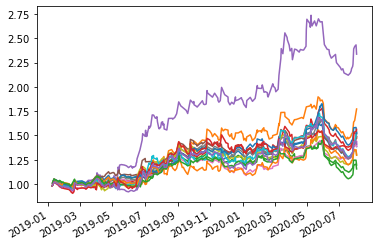

In [23]:
for i in range(len(cumRets)):
    cumRets[i].plot()

### Potential issues:

. Because of purging, the current method for splitting up the train and test sets results in every test set missing a couple of days of purged data. Fix this by making sure purged test sets together add up to the whole time series.<br>
. Open positions are forced to close when transitioning from one group to another non-contiguous group. The frequency and magnitude of this issue depends on the number of groups and the turnover of the strategy. This source of distortion needs to be examined further.

In [24]:
#import pickle
#pickle.dump(returns_cv, open( "mixed_bollinger_cpcv_7_3_40", "wb" ) )